In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1) Implement a class named NeuralNetwork which takes as input the following parameters:
1. N: Number of layers in the network
2. A list of size N specifying the number of neurons in each layer
3. lr: Learning rate
4. Activation function (same activation function is used in all layers of the network except the last layer)
5. Weight initialization function
6. Number of epochs
7. Batch size
# The NeuralNetwork class should also implement the following functions:
1. fit(X, Y): trains a model on input data X and labels Y
2. predict(X): gives the prediction for input X
3. predict proba(X): gives the class wise probability for input X
4. score(X, Y): gives the accuracy of the trained model in input X and labels Y
# Use of helper functions like forward, backward, reset gradients is recommended to simplify implementation. You can also create helper classes.

# 2) You need to implement the following activation functions (along with their gradient functions): sigmoid, tanh, ReLU, Leaky ReLU, linear and softmax (only used in last layer).

# 3) You need to implement the following weight initialization functions: zero init, random init and normal init (Normal(0, 1)). Choose appropriate scaling factors.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras.datasets.mnist as mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
print(np.isnan(np.sum(X_train)))
print(np.isnan(np.sum(X_test)))

False
False


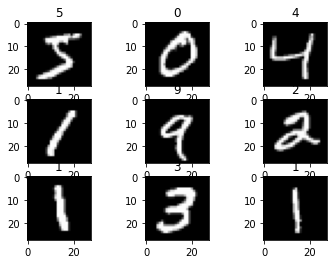

In [5]:
fig,ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(X_train[i*3+j], cmap='gray')
        ax[i, j].set_title(y_train[i * 3 + j])
plt.show()

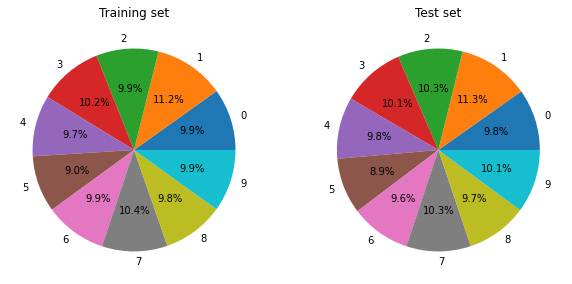

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pie([np.sum(y_train == i) for i in range(10)], labels=[str(i) for i in range(10)], autopct='%1.1f%%')
ax[0].set_title('Training set')
ax[1].pie([np.sum(y_test == i) for i in range(10)], labels=[str(i) for i in range(10)], autopct='%1.1f%%')
ax[1].set_title('Test set')
plt.show()

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [8]:
print(X_test[0])
print(X_test[0].shape)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 222 254 254 254 254 241 198 198 198 19

In [9]:
number_of_instances,x_component,y_component=X_train.shape
X_train=X_train.reshape((number_of_instances,x_component*y_component))
print(X_train.shape)
number_of_instances,x_component,y_component=X_test.shape
X_test=X_test.reshape((number_of_instances,x_component*y_component))
print(X_test.shape)

(60000, 784)
(10000, 784)


In [10]:
X_train=(X_train-np.mean(X_train))/np.std(X_train)
X_test=(X_test-np.mean(X_test))/np.std(X_test)

In [11]:
y_train=np.eye(10)[y_train]
y_test=np.eye(10)[y_test]

In [12]:
class NeuralNetwork:
    def zero_init(self, shape):
        return np.zeros(shape)
    
    def random_init(self,shape):
        return np.random.rand(shape[0],shape[1])
    
    def normal_init(self,shape):
        return np.random.normal(0,1,shape)
    
    def __init__(self,N,A,lr,activation_function,weight_initialisation_function,number_of_epochs,batch_size):
        self.A=A
        self.weights=[]
        self.biases=[]
        self.weight_initialisation_function=weight_initialisation_function
        self.N=N
        if self.weight_initialisation_function=='random':
            for i in range(self.N-1):
                self.weights.append(self.random_init((self.A[i],self.A[i+1])))
        elif self.weight_initialisation_function=='zero':
            for i in range(self.N-1):
                self.weights.append(self.zero_init((self.A[i],self.A[i+1])))
        elif self.weight_initialisation_function=='normal':
            for i in range(self.N-1):
                self.weights.append(self.normal_init((self.A[i],self.A[i+1])))
        else:
            print('Invalid weight_initialisation_function')
            return
        i=0
        while i<self.N-1:
            self.biases.append(np.zeros((1,self.A[i+1])))
            i+=1
        self.training_loss=[]
        self.validation_loss=[]
        self.number_of_epochs=number_of_epochs
        self.delta=[]
        self.lr=lr
        self.batch_size=batch_size
        self.gradient=[]
        self.activation=[]
        self.activation_function=activation_function

    def sigmoid(self,X):
        return 1/(1+np.exp(-X))

    def sigmoid_gradient(self,X):
        return self.sigmoid(X)*(1-self.sigmoid(X))
    
    def tanh(self,X):
        return np.tanh(X)

    def tanh_gradient(self,X):
        return 1-np.square(np.tanh(X))

    def relu(self,X):
        return np.maximum(0,X)

    def relu_gradient(self,X):
        X[X<=0] = 0
        X[X>0] = 1
        return X

    def leaky_relu(self,X):
        return np.maximum(0.01*X,X)

    def leaky_relu_gradient(self,X):
        X[X<=0] = 0.01
        X[X>0] = 1
        return X

    def linear(self,X):
        return X

    def linear_gradient(self,X):
        return np.ones(X.shape)

    def softmax(self,X):
        return np.exp(X-np.max(X))/np.sum(np.exp(X-np.max(X)))

    def softmax_gradient(self,X):
        return X*(1-X)

    def forward(self,X):
        self.activation.clear()
        self.activation.append(X)
        if self.activation_function=='sigmoid':
            for i in range(self.N-2):
                if(len(self.activation[i])<len(self.biases[i])):
                    break
                self.activation.append(self.sigmoid(np.dot(self.activation[i],self.weights[i])+self.biases[i]))
        elif self.activation_function=='tanh':
            for i in range(self.N-2):
                if(len(self.activation[i])<len(self.biases[i])):
                    break
                self.activation.append(self.tanh(np.dot(self.activation[i],self.weights[i])+self.biases[i]))
        elif self.activation_function=='relu':
            for i in range(self.N-2):
                if(len(self.activation[i])<len(self.biases[i])):
                    break
                self.activation.append(self.relu(np.dot(self.activation[i],self.weights[i])+self.biases[i]))
        elif self.activation_function=='leaky_relu':
            for i in range(self.N-2):
                if(len(self.activation[i])<len(self.biases[i])):
                    break
                self.activation.append(self.leaky_relu(np.dot(self.activation[i],self.weights[i])+self.biases[i]))
        elif self.activation_function=='linear':
            for i in range(self.N-2):
                if(len(self.activation[i])<len(self.biases[i])):
                    break
                self.activation.append(self.linear(np.dot(self.activation[i],self.weights[i])+self.biases[i]))
        else:
            print('Invalid activation_function')
            return
        self.activation.append(self.predict_proba(X))
        return self.activation[self.N-1]

    def backward(self,X,Y):
        self.delta.clear()
        self.delta.append(self.activation[self.N-1]-Y)
        self.gradient.clear()

        if self.activation_function=='sigmoid':
            for i in range(self.N-2,0,-1):
                self.delta.append(np.dot(self.delta[self.N-i-2],self.weights[i].T)*self.sigmoid_gradient(self.activation[i]))
        elif self.activation_function=='tanh':
            for i in range(self.N-2,0,-1):
                self.delta.append(np.dot(self.delta[self.N-i-2],self.weights[i].T)*self.tanh_gradient(self.activation[i]))
        elif self.activation_function=='relu':
            for i in range(self.N-2,0,-1):
                self.delta.append(np.dot(self.delta[self.N-i-2],self.weights[i].T)*self.relu_gradient(self.activation[i]))
        elif self.activation_function=='leaky_relu':
            for i in range(self.N-2,0,-1):
                self.delta.append(np.dot(self.delta[self.N-i-2],self.weights[i].T)*self.leaky_relu_gradient(self.activation[i]))
        elif self.activation_function=='linear':
            for i in range(self.N-2,0,-1):
                self.delta.append(np.dot(self.delta[self.N-i-2],self.weights[i].T)*self.linear_gradient(self.activation[i]))
        else:
            print('Invalid activation_function')
            return
        i=0
        while i<self.N-1:
            self.gradient.append(np.dot(self.activation[i].T,self.delta[self.N-2-i]))
            i+=1

    def fit(self,X,Y,X_val,Y_val):
        for i in range(self.number_of_epochs):
            for j in range(0,len(X)-self.batch_size,self.batch_size):
                self.forward(X[j:j+self.batch_size])
                self.backward(X[j:j+self.batch_size],Y[j:j+self.batch_size])
                k=0
                while k<self.N-1:
                    self.biases[k]=self.biases[k]-self.lr*self.delta[self.N-k-2]
                    self.weights[k]=self.weights[k]-self.lr*self.gradient[k]
                    k+=1
            loss=[]
            for j in range(0,len(X)-self.batch_size,self.batch_size):
                activation_end=self.forward(X[j:j+self.batch_size])
                counter=0
                for k in range(self.batch_size):
                    counter+= -Y[j+k]*np.log(activation_end[k]+1e-14)
                loss.append(counter/self.batch_size)
            self.training_loss.append(np.mean(loss))
            loss=[]
            for j in range(0,len(X_val)-self.batch_size,self.batch_size):
                activation_end=self.forward(X_val[j:j+self.batch_size])
                counter=0
                for k in range(self.batch_size):
                    counter+= -Y_val[j+k]*np.log(activation_end[k]+1e-14)
                loss.append(counter/self.batch_size)
            self.validation_loss.append(np.mean(loss))

    def predict(self,X):
        return self.forward(X)

    def predict_proba(self,X):
        return self.softmax(np.dot(self.activation[self.N-2],self.weights[self.N-2])+self.biases[self.N-2])
    
    def score(self,X,Y):
        correct=0
        y_pred=self.predict(X)
        i=0
        while i<len(y_pred):
            if np.argmax(y_pred[i])==np.argmax(Y[i]):
                correct+=1
            i+=1
        return correct/len(y_pred)

# 4) Train the above implemented network on MNIST dataset. Perform appropriate preprocessing. Use the following configurations for training the network:
1. Number of hidden layers = 4
2. Layer sizes = [256,128,64,32]
3. Number of epochs = 100 (can be less if computation is taking too long)
4. Batch size = 128 (or any other appropriate batch size)
# Choose the remaining parameters appropriately. Plot training loss v/s epochs and validation loss v/s epochs for each activation function. Also, save all the trained models as you might be asked to run them during the demo (TAs won’t wait for the model to train). Note that it is possible that your training is stuck in a local minimum. Try fiddling around with the batch size.

0.09685496794871795


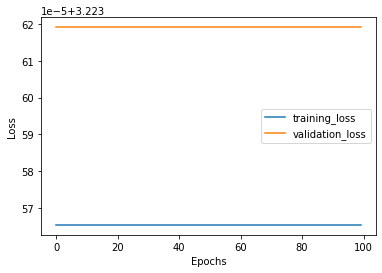

In [13]:
nn1=NeuralNetwork(6,[784,256,128,64,32,10],0.001,"relu","normal",100,128)
nn1.fit(X_train,y_train,X_test,y_test)
score=[]
for i in range(0,len(X_test)-len(X_test)%nn1.batch_size,nn1.batch_size):
    score.append(nn1.score(X_test[i:i+nn1.batch_size],y_test[i:i+nn1.batch_size]))
print(np.mean(score))
plt.plot(nn1.training_loss)
plt.plot(nn1.validation_loss)
plt.legend(['training_loss','validation_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [14]:
print(nn1.training_loss)
print(score)
print(nn1.validation_loss)

[3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317

0.10857371794871795


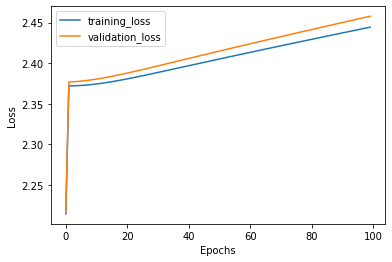

In [15]:
nn2=NeuralNetwork(6,[784,256,128,64,32,10],0.005,"sigmoid","random",100,64)
nn2.fit(X_train,y_train,X_test,y_test)
score=[]
for i in range(0,len(X_test)-len(X_test)%nn2.batch_size,nn2.batch_size):
    score.append(nn2.score(X_test[i:i+nn2.batch_size],y_test[i:i+nn2.batch_size]))
print(np.mean(score))
plt.plot(nn2.training_loss)
plt.plot(nn2.validation_loss)
plt.legend(['training_loss','validation_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [16]:
print(nn2.training_loss)
print(score)
print(nn2.validation_loss)

[2.2140618246153028, 2.3719668976061192, 2.3719985912787602, 2.3720950144061907, 2.37225283819419, 2.3724687251939103, 2.3727394021369133, 2.373061655331592, 2.373432329575407, 2.373848329796929, 2.3743066249091846, 2.3748042534715506, 2.375338330752524, 2.3759060567290895, 2.376504724506256, 2.3771317286327562, 2.3777845728433227, 2.378460876856235, 2.3791583819758895, 2.3798749553690484, 2.3806085929757654, 2.3813574210874675, 2.382119696650034, 2.3828938063803737, 2.383678264779107, 2.3844717111285827, 2.3852729055707913, 2.386080724366256, 2.386894154444021, 2.387712287369725, 2.388534312861271, 2.3893595119921724, 2.3901872502208046, 2.3910169703735313, 2.391848185711073, 2.3926804731710622, 2.3935134668874696, 2.394346852051114, 2.3951803591576324, 2.396013758686657, 2.3968468562168095, 2.397679487992298, 2.3985115169232265, 2.3993428290149055, 2.400173330189383, 2.4010029434872866, 2.401831606609461, 2.4026592697746754, 2.403485893856729, 2.4043114487759323, 2.4051359121131424, 

0.10997596153846154


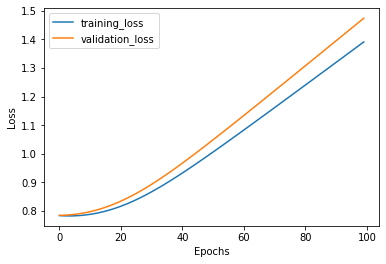

In [17]:
nn3=NeuralNetwork(6,[784,256,128,64,32,10],0.01,"tanh","zero",100,256)
nn3.fit(X_train,y_train,X_test,y_test)
score=[]
for i in range(0,len(X_test)-len(X_test)%nn3.batch_size,nn3.batch_size):
    score.append(nn3.score(X_test[i:i+nn3.batch_size],y_test[i:i+nn3.batch_size]))
print(np.mean(score))
plt.plot(nn3.training_loss)
plt.plot(nn3.validation_loss)
plt.legend(['training_loss','validation_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [18]:
print(nn3.training_loss)
print(score)
print(nn3.validation_loss)

[0.7839347708605015, 0.7833196404378958, 0.7829330963931438, 0.7827773193115215, 0.7828544136996309, 0.7831663830052393, 0.7837151023146811, 0.7845022886729209, 0.7855294690174333, 0.7867979457767895, 0.7883087602612656, 0.7900626540689525, 0.7920600288494392, 0.7943009049098667, 0.7967848793150255, 0.7995110843214341, 0.8024781471885354, 0.8056841526169674, 0.8091266092575928, 0.8128024218933485, 0.8167078709922461, 0.8208386013350774, 0.8251896213081508, 0.8297553141989022, 0.8345294624318315, 0.8395052851424564, 0.844675488836726, 0.8500323301716415, 0.8555676891847029, 0.8612731506679145, 0.867140090895836, 0.8731597666311255, 0.8793234032754353, 0.8856222792092654, 0.8920478037434517, 0.8985915866362909, 0.9052454977493865, 0.9120017160551223, 0.9188527678096431, 0.9257915542221534, 0.9328113693567083, 0.9399059092864749, 0.9470692736871756, 0.9542959611209701, 0.9615808592449301, 0.9689192311017713, 0.9763066985356732, 0.9837392236407934, 0.991213089008478, 0.9987248774013553, 1.

0.09685496794871795


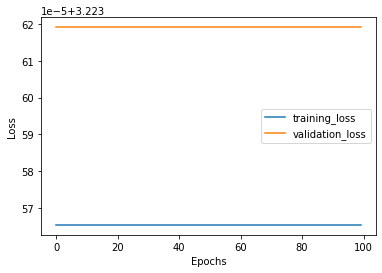

In [19]:
nn4=NeuralNetwork(6,[784,256,128,64,32,10],0.05,"leaky_relu","random",100,128)
nn4.fit(X_train,y_train,X_test,y_test)
score=[]
for i in range(0,len(X_test)-len(X_test)%nn4.batch_size,nn4.batch_size):
    score.append(nn4.score(X_test[i:i+nn4.batch_size],y_test[i:i+nn4.batch_size]))
print(np.mean(score))
plt.plot(nn4.training_loss)
plt.plot(nn4.validation_loss)
plt.legend(['training_loss','validation_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [20]:
print(nn4.training_loss)
print(score)
print(nn4.validation_loss)

[3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317105222, 3.223565317